In [1]:
# import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt5"
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from mne.time_frequency import psd_array_multitaper
import os
from config import Config
configObj = Config()
configss = configObj.getConfigSnapshot()

# Assuming EEG data is in MNE format (Epochs or Raw). Placeholder for file path to participants' data
data_dir = "path_to_data"

# Frequency bands definitions
freq_bands = {'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}

# Placeholder for results
results = []


In [6]:
def extract_psd_features(epochs, fmin, fmax):
    """Extract Power Spectral Density (PSD) features using psd_array_multitaper for a given frequency band."""
    psds = []
    for epoch in epochs.get_data():
        # Calculate the PSD for each epoch
        psd, freqs = psd_array_multitaper(epoch, sfreq=epochs.info['sfreq'], fmin=fmin, fmax=fmax, verbose=False)
        # Average PSD across the desired frequency band
        psds.append(np.mean(psd, axis=1))
    return np.array(psds)

def get_psd_features(epochs, freq_bands):
    """Extract PSD features for the theta, alpha, and beta bands."""
    features = []
    for band, (fmin, fmax) in freq_bands.items():
        psd_band = extract_psd_features(epochs, fmin, fmax)
        features.append(psd_band)
    return np.concatenate(features, axis=1)


In [13]:
def collect_band_power_topography(epochs, freq_bands, band_power_dict):
    """Collect the average band power for grand averaging across participants."""
    
    for band, (fmin, fmax) in freq_bands.items():
        psds = []
        
        for epoch in epochs.get_data():
            # Calculate the PSD for each epoch in the band
            psd, freqs = psd_array_multitaper(epoch, sfreq=epochs.info['sfreq'], fmin=fmin, fmax=fmax, verbose=False)
            psds.append(np.mean(psd, axis=1))  # Average over frequencies for each channel
        
        # Convert to array and compute mean PSD across epochs
        psds = np.array(psds)
        psd_mean = np.mean(psds, axis=0)  # Average across epochs for each channel
        
        # Add to the grand average dictionary for the current band
        if band not in band_power_dict:
            band_power_dict[band] = []
        band_power_dict[band].append(psd_mean)


In [14]:
# Function to compute and plot grand average band power topography
def plot_grand_average_band_power_topography(band_power_dict, condition_name, epochs_info):
    """Plot the grand average band power topography for each frequency band."""
    for band, band_power_list in band_power_dict.items():
        # Compute grand average band power across participants
        grand_average_band_power = np.mean(band_power_list, axis=0)
        
        # Plot topography
        plt.figure(figsize=(6, 4))
        mne.viz.plot_topomap(grand_average_band_power, epochs_info, show=True)
        plt.title(f'{band.capitalize()} Band Power Topography - Grand Average {condition_name}')
        plt.show()

In [9]:
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.model_selection import KFold

def classify_participant(X, y, classifiers, participant_id, freq_bands, n_components=4):
    """
    Run classification for a participant using multiple classifiers and return results.
    CSP is calculated for each power band separately, and transformations are applied to both train and test data.
    The CSP-transformed data is normalized using StandardScaler.

    Parameters:
    - X: Combined EEG data from both conditions (epochs.get_data()).
    - y: Combined labels (1 for Condition 1, 0 for Condition 2).
    - classifiers: Dictionary of classifiers to use.
    - participant_id: ID of the participant.
    - freq_bands: Dictionary of frequency bands (e.g., {'theta': (4, 8), 'alpha': (8, 12)}).
    - n_components: Number of CSP components to retain.

    Returns:
    - participant_results: List of classification results (mean and std accuracies).
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    participant_results = []
    
    # Initialize CSP for each frequency band
    csp_dict = {band: CSP(n_components=n_components, reg='oas', log=True, norm_trace=False) for band in freq_bands.keys()}
    
    for clf_name, clf in classifiers.items():
        # Store accuracies for each fold
        fold_accuracies = []
        
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Apply CSP to each frequency band
            X_train_csp = []
            X_test_csp = []
            
            for band, (fmin, fmax) in freq_bands.items():
                # Train CSP on the training data for this band
                csp = csp_dict[band]
                csp.fit(X_train, y_train)
                
                # Transform both training and test data using the trained CSP
                X_train_csp_band = csp.transform(X_train)
                X_test_csp_band = csp.transform(X_test)
                
                # Append CSP-transformed data for the current band
                X_train_csp.append(X_train_csp_band)
                X_test_csp.append(X_test_csp_band)
            
            # Concatenate CSP features from all bands
            X_train_csp = np.concatenate(X_train_csp, axis=1)
            X_test_csp = np.concatenate(X_test_csp, axis=1)
            
            # Normalize (standardize) the CSP-transformed data
            scaler = StandardScaler()
            X_train_csp = scaler.fit_transform(X_train_csp)  # Fit scaler on training data
            X_test_csp = scaler.transform(X_test_csp)        # Apply scaler to test data
            
            # Clone the classifier to ensure a fresh model for each fold
            clf_clone = clone(clf)
            
            # Train the classifier on the CSP-transformed training data
            clf_clone.fit(X_train_csp, y_train)
            
            # Test on the CSP-transformed test data and calculate accuracy
            accuracy = clf_clone.score(X_test_csp, y_test)
            fold_accuracies.append(accuracy)
        
        # Store mean and standard deviation of accuracy for the classifier
        participant_results.append({
            'participant': participant_id,
            'classifier': clf_name,
            'mean_accuracy': np.mean(fold_accuracies),
            'std_accuracy': np.std(fold_accuracies)
        })
    
    return participant_results


In [4]:
import os
import mne

def load_participant_epochs(pnum, condition):
    """Load and concatenate epochs for a participant across multiple blocks for a given condition.
    
    Parameters:
    - pnum: Participant number (integer)
    - condition: Condition (e.g., 'D' or 'ND')
    
    Returns:
    - concatenated_epochs: Concatenated MNE epochs object for the participant
    """
    
    # Initialize an empty list to store the epochs from each block
    epochs_list = []
    
    # Loop through all 4 blocks
    for b_cnt in range(0, 4):
        # Create the block numbers by appending the current block count to the condition
        block_num = f"{condition}{b_cnt}"
        
        # Construct the participant's folder name
        participant_number = 'P' + str(pnum)
        # Create the full path to the epochs file
        participant_data_path = participant_number + '/' + block_num + '-epo.fif'
        path = os.path.join(configss['root'], configss['data_dir'], participant_data_path)
        
        # Load the epochs file for this block
        epochs = mne.read_epochs(path, preload=True)
        
        # Append the loaded epochs to the list
        epochs_list.append(epochs)
    
    # Concatenate all the loaded epochs from the list
    concatenated_epochs = mne.concatenate_epochs(epochs_list)
    
    return concatenated_epochs


In [10]:
# Define frequency bands (example: theta, alpha, beta)
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}

# Define classifiers to test
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier()
}

event_count_condition1 = {}
event_count_condition2 = {}
band_power_condition1 = {}
band_power_condition2 = {}

valid_pids = [el for el in list(range(1, 32)) if el not in [14, 5, 13, 16, 17, 20, 31]]

# Iterate through all participants
for participant_id in valid_pids:

    epochs_condition1 = load_participant_epochs(participant_id, 'D')
    epochs_condition2 = load_participant_epochs(participant_id, 'ND')
    
    # Combine both epochs for classification
    combined_epochs = mne.concatenate_epochs([epochs_condition1, epochs_condition2])

    # Get combined data
    X_combined = combined_epochs.get_data()

    n_epochs_condition1 = len(epochs_condition1)
    n_epochs_condition2 = len(epochs_condition2)

    # Manually assign labels for Condition 1 (as 1) and Condition 2 (as 0)
    y_condition1 = np.ones(n_epochs_condition1, dtype=int)  # Label all epochs in Condition 1 as 1
    y_condition2 = np.zeros(n_epochs_condition2, dtype=int)  # Label all epochs in Condition 2 as 0

    # Combine the labels
    y_combined = np.concatenate([y_condition1, y_condition2], axis=0)

    # Run classification and store results
    participant_results = classify_participant(X_combined, y_combined, classifiers, participant_id, freq_bands)
    results.extend(participant_results)

# Example to print or analyze results later
results_df = pd.DataFrame(results)
results_df.to_csv('classification_results_2.csv', index=False)


Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D0-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D1-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\erangad\Desktop\Research\reading_task\ov_experiment\scenarios\data\P1\D2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Reading c:\Users\

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


829 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 62 dim * 1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 62 dim * 1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 62 dim * 1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating c

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
843 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.7e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.7e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.7e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 62 dim * 8e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 62 dim * 8e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 62 dim * 8e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 cova

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 62 dim * 7.5e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 62 dim * 7.5e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 62 dim * 7.5e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 c

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 62 dim * 1.2e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 62 dim * 1.2e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 62 dim * 1.2e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance us

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 62 dim * 1.1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 62 dim * 1.1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 62 dim * 1.1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance us

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


875 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 62 dim * 1.4e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 62 dim * 1.4e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 62 dim * 1.4e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estima

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 62 dim * 1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 62 dim * 1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 62 dim * 1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 cova

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 62 dim * 8.1e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 62 dim * 8.1e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 62 dim * 8.1e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 8.1e-05 (2.2e-16 eps * 62 dim * 5.9e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-05 (2.2e-16 eps * 62 dim * 5.9e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-05 (2.2e-16 eps * 62 dim * 5.9e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


883 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 62 dim * 8.1e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 62 dim * 8.1e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 62 dim * 8.1e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estima

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 62 dim * 7.3e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 62 dim * 7.3e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 62 dim * 7.3e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 c

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.4e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.4e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.4e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
889 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 62 dim * 1.1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 62 dim * 1.1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 62 dim * 1.1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


888 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 62 dim * 1.1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 62 dim * 1.1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 62 dim * 1.1e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estima

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Not setting metadata
905 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 62 dim * 1.5e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 62 dim * 1.5e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 62 dim * 1.5e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank fr

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


825 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 62 dim * 1.4e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 62 dim * 1.4e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 62 dim * 1.4e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estima

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


749 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 62 dim * 1.3e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 62 dim * 1.3e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 62 dim * 1.3e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estima

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 62 dim * 1.2e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 62 dim * 1.2e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 62 dim * 1.2e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.5e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.5e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.5e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.4e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.4e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.4e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 62 dim * 1.4e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 62 dim * 1.4e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 62 dim * 1.4e+10  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.1e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.1e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 62 dim * 9.1e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)
C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\3434236470.py:36: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  concatenated_epochs = mne.concatenate_epochs(epochs_list)


835 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 62 dim * 7.3e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 62 dim * 7.3e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 62 dim * 7.3e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimatin

C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\1717857455.py:62: RuntimeWarning: filter_length (413) is longer than the signal (250), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_band = epochs.copy().filter(l_freq=fmin, h_freq=fmax, verbose=False)


Computing rank from data with rank=None
    Using tolerance 7.5e-05 (2.2e-16 eps * 62 dim * 5.5e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.


C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\1717857455.py:62: RuntimeWarning: filter_length (413) is longer than the signal (250), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_band = epochs.copy().filter(l_freq=fmin, h_freq=fmax, verbose=False)


Computing rank from data with rank=None
    Using tolerance 6e-05 (2.2e-16 eps * 62 dim * 4.4e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.


C:\Users\erangad\AppData\Local\Temp\ipykernel_6608\1717857455.py:62: RuntimeWarning: filter_length (275) is longer than the signal (250), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_band = epochs.copy().filter(l_freq=fmin, h_freq=fmax, verbose=False)


Computing rank from data with rank=None
    Using tolerance 6.8e-05 (2.2e-16 eps * 62 dim * 4.9e+09  max singular value)
    Estimated rank (data): 62
    data: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.


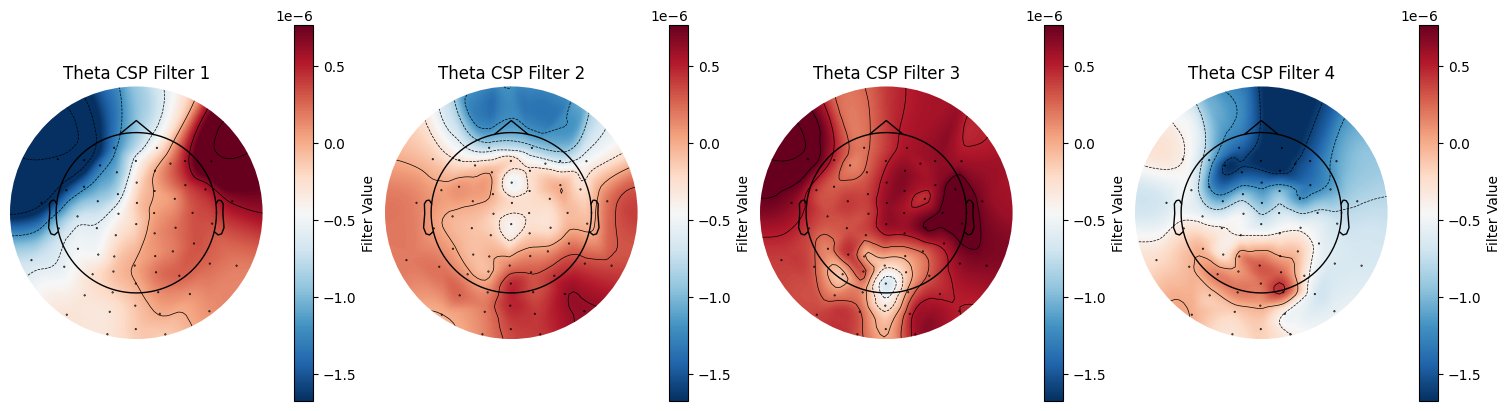

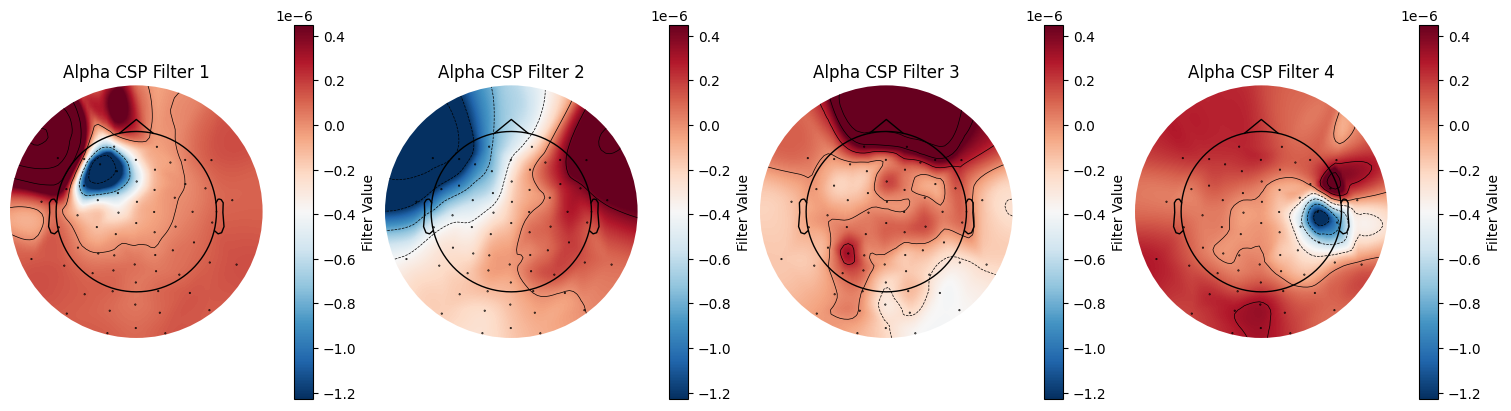

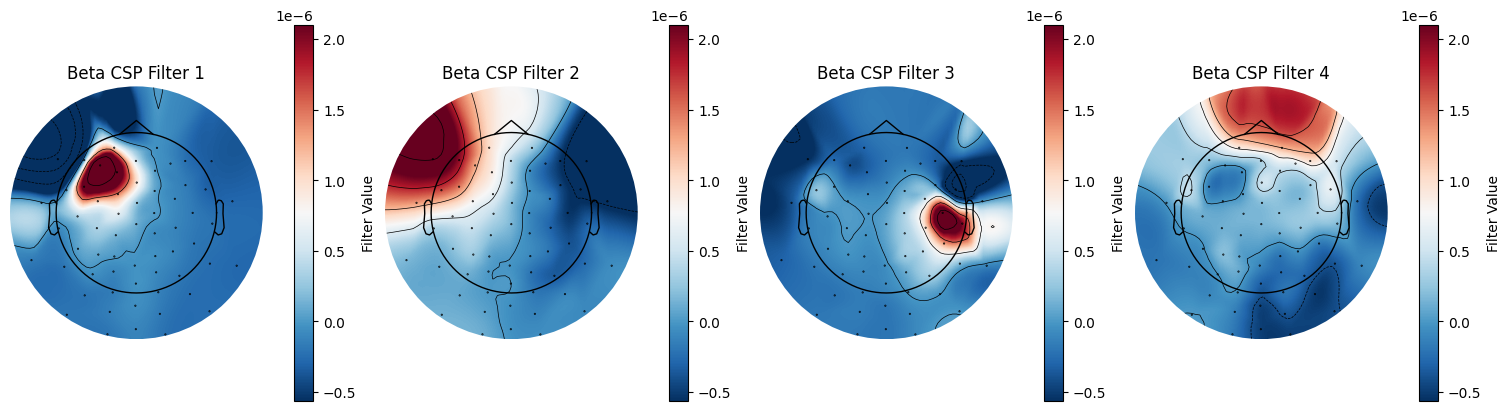

In [20]:
def plot_csp_topographies(csp_filters, epochs_info, freq_bands, n_components):
    """
    Plot CSP topographies for each frequency band, limiting to n_components.
    
    Parameters:
    - csp_filters: Dictionary of CSP filters for each band.
    - epochs_info: EEG channel information (from epochs.info).
    - freq_bands: Dictionary of frequency bands (e.g., {'theta': (4, 8), 'alpha': (8, 12)}).
    - n_components: Number of CSP components to plot.
    """
    # Calculate vmin and vmax per band
    vmin_vmax_per_band = calculate_vmin_vmax_per_band_csp(csp_filters)
    
    for band in csp_filters.keys():  # Iterate over all frequency bands
        csp_filters_band = csp_filters[band][:n_components]  # Limit to the top n_components

        # Get vmin and vmax for the current band
        vmin, vmax = vmin_vmax_per_band[band]

        # Determine the number of filters (components) to plot
        n_filters = len(csp_filters_band)
        n_cols = 4  # Number of columns in the subplot
        n_rows = int(np.ceil(n_filters / n_cols))  # Calculate the number of rows

        # Create subplots with multiple rows/columns for better layout
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), constrained_layout=True)
        axes = axes.flatten()  # Flatten axes for easy iteration

        for i, csp_filter in enumerate(csp_filters_band):
            im, _ = mne.viz.plot_topomap(
                csp_filter, epochs_info, axes=axes[i], show=False, cmap='RdBu_r', vlim=(vmin, vmax)
            )
            axes[i].set_title(f'{band.capitalize()} CSP Filter {i+1}')
            cbar = plt.colorbar(im, ax=axes[i])
            cbar.set_label('Filter Value')

        # Remove any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.show()

# Example of how to generate CSP filters and plot them
def compute_and_plot_csp_topographies(epochs, y_combined, freq_bands, epochs_info, n_components=4):
    """
    Compute CSP for each frequency band and plot the resulting spatial filters as topographies.
    
    Parameters:
    - epochs: MNE epochs object (or raw data).
    - y_combined: Labels for the data (1 for Condition 1, 0 for Condition 2).
    - freq_bands: Dictionary of frequency bands (e.g., {'theta': (4, 8), 'alpha': (8, 12)}).
    - epochs_info: EEG channel information (from epochs.info).
    - n_components: Number of CSP components to retain and plot.
    """
    csp_filters = {}

    for band, (fmin, fmax) in freq_bands.items():
        # Initialize CSP for this frequency band
        csp = CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        
        # Filter the epochs data to focus on this frequency band
        epochs_band = epochs.copy().filter(l_freq=fmin, h_freq=fmax, verbose=False)
        
        # Fit CSP to the filtered data
        csp.fit(epochs_band.get_data(), y_combined)
        
        # Store the spatial filters (patterns) for this band, limit to n_components
        csp_filters[band] = csp.patterns_[:n_components]  # Only retain the top n_components
    
    # Plot the topographies
    plot_csp_topographies(csp_filters, epochs_info, freq_bands, n_components)

# Example usage:
freq_bands = {'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}

# Assuming `combined_epochs`, `y_combined`, and `epochs_condition1.info` are available:
compute_and_plot_csp_topographies(combined_epochs, y_combined, freq_bands, epochs_condition1.info, n_components=4)


In [ ]:
# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('classification_result_2.csv', index=False)